# COMP4318/5318 Assignment 2: Image Classification

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [109]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from scikeras.wrappers import KerasClassifier

from scipy.stats import randint, uniform
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [8]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [9]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (32000, 28, 28, 3)
Shape of y_train: (32000,)
Shape of X_test: (8000, 28, 28, 3)
Shape of y_test: (8000,)


In [10]:
y_test[:5]

array([1, 6, 4, 7, 1], dtype=uint8)

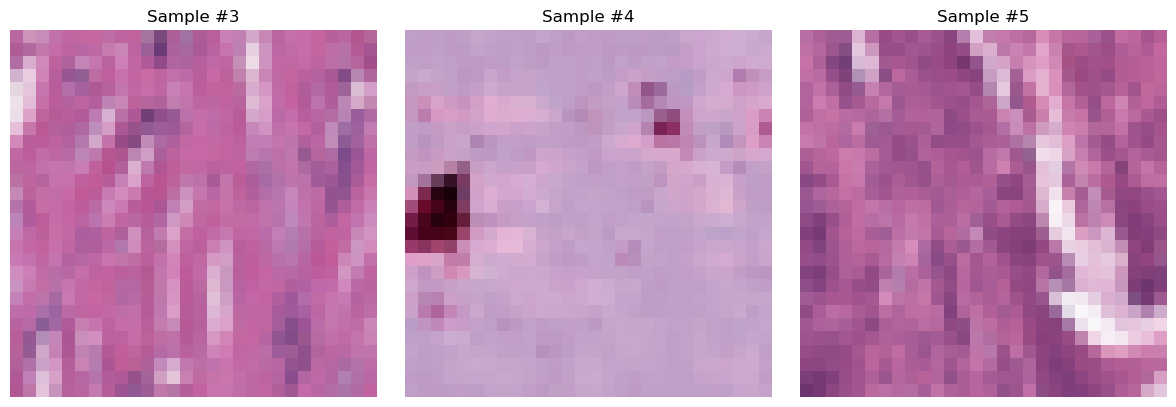

In [11]:
X_orig_samples = X_test[3:6]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(X_orig_samples[i])
    ax.set_title(f"Sample #{3+i}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [12]:
#handle missing values
def clean(array, missing_values=None):
    cleaned = array.copy().astype(float)
    if missing_values is None:
        missing_values = [None, '']
   
    for missing in missing_values:
        cleaned[cleaned == missing] = np.nan
    return cleaned
    
X_train_clean = clean(X_train)
y_train_clean = clean(y_train)
X_test_clean = clean(X_test)
y_test_clean = clean(y_test)

print("How many missing values in X_train？", np.isnan(X_train_clean).sum())
print("How many missing values in y_train？", np.isnan(y_train_clean).sum())
print("How many missing values in X_test？", np.isnan(X_test_clean).sum())
print("How many missing values in y_test？", np.isnan(y_test_clean).sum())

How many missing values in X_train？ 0
How many missing values in y_train？ 0
How many missing values in X_test？ 0
How many missing values in y_test？ 0


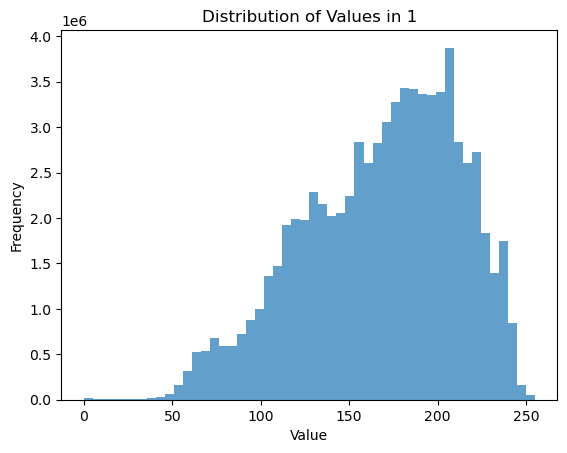

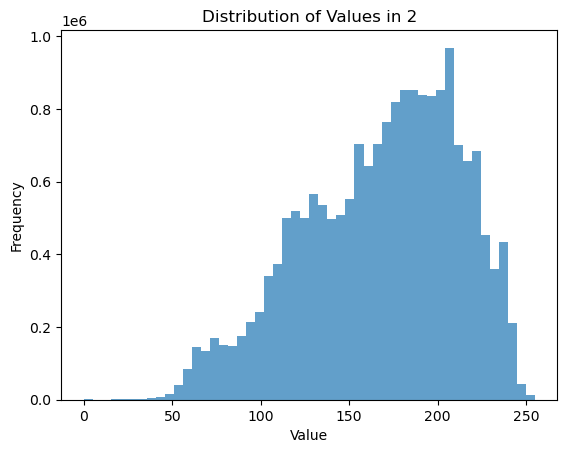

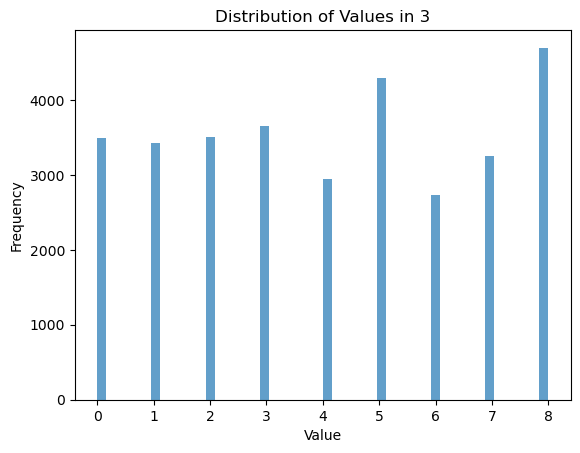

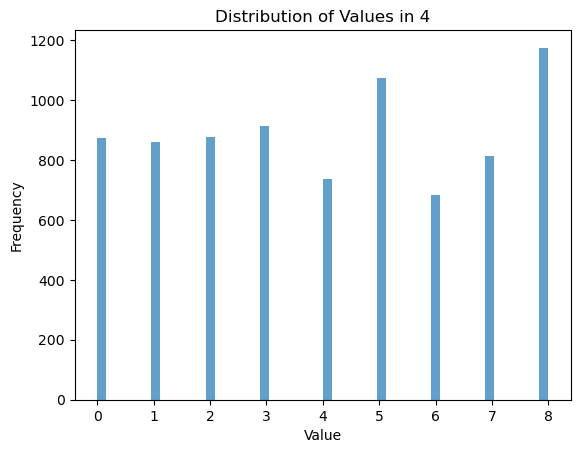

In [13]:
#draw histogram to show distribution
def hist(data,num):
    plt.hist(data.flatten(), bins=50, alpha=0.7)
    plt.title(f"Distribution of Values in {num}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

hist(X_train_clean,1)
hist(X_test_clean,2)
hist(y_train_clean,3)
hist(y_test_clean,4)

In [14]:
# Convert data to 32-bit floating point
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
# Scale pixel values from the range [0, 255] to [0.0, 1.0]
X_train /= 255.0
X_test  /= 255.0

In [15]:
# Create validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, train_size=0.8)

y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)

## 2. Algorithm design and setup

### Logistic Regression

In [18]:
from sklearn.decomposition import PCA

# Flatten and standardization
X_train_flat = X_train.reshape(X_train.shape[0], -1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)

cvKFold = KFold(n_splits=5, shuffle=True, random_state=0)

# PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)

def LR(X, y):
    model = LogisticRegression(solver='liblinear', max_iter=500, random_state=0)
    scores = cross_val_score(model, X, y, cv=3)
    return scores.mean()

lr_acc = LR(X_train_pca, y_train)
print(f"Accuracy: {lr_acc:.4f}")


Accuracy: 0.4678


### Feedforward Multilayer Perceptron Neural Network (MLP)

In [20]:
# Onehot
y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)

# Construct the model
mlp_model = Sequential([
    Flatten(input_shape=(28, 28, 3)),
    Dense(128, activation='relu'),
    Dense(9, activation='softmax')
])

mlp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = mlp_model.fit(X_train, y_train_cat,
                        validation_data=(X_valid, y_valid_cat),
                        epochs=10,
                        batch_size=32,
                        verbose=2)



E:\AVO\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
800/800 - 7s - 8ms/step - accuracy: 0.2649 - loss: 1.9350 - val_accuracy: 0.3558 - val_loss: 1.7927
Epoch 2/10
800/800 - 4s - 5ms/step - accuracy: 0.3503 - loss: 1.7412 - val_accuracy: 0.3992 - val_loss: 1.6531
Epoch 3/10
800/800 - 4s - 5ms/step - accuracy: 0.3867 - loss: 1.6636 - val_accuracy: 0.4006 - val_loss: 1.6557
Epoch 4/10
800/800 - 4s - 5ms/step - accuracy: 0.3993 - loss: 1.6329 - val_accuracy: 0.4180 - val_loss: 1.5883
Epoch 5/10
800/800 - 4s - 5ms/step - accuracy: 0.4129 - loss: 1.6203 - val_accuracy: 0.4366 - val_loss: 1.5773
Epoch 6/10
800/800 - 4s - 5ms/step - accuracy: 0.4149 - loss: 1.5926 - val_accuracy: 0.4081 - val_loss: 1.5739
Epoch 7/10
800/800 - 4s - 4ms/step - accuracy: 0.4340 - loss: 1.5486 - val_accuracy: 0.4492 - val_loss: 1.5007
Epoch 8/10
800/800 - 4s - 5ms/step - accuracy: 0.4482 - loss: 1.5143 - val_accuracy: 0.4250 - val_loss: 1.5044
Epoch 9/10
800/800 - 4s - 5ms/step - accuracy: 0.4567 - loss: 1.4912 - val_accuracy: 0.4433 - val_loss: 1.5201
E

In [21]:
val_loss, val_acc = mlp_model.evaluate(X_valid, y_valid_cat, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.4747


### Convolutional neural network

In [23]:
#Build cnn model
cnn_model = keras.Sequential([
    
    # Specify the input shape
    keras.Input(shape=(28, 28, 3)),
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,402 (138.29 KB)

 Trainable params: 35,402 (138.29 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile model with loss, optimiser, and metrics
cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [25]:
# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 10
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2546 - loss: 1.9888 - val_accuracy: 0.4858 - val_loss: 1.3710
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5001 - loss: 1.3207 - val_accuracy: 0.5886 - val_loss: 1.1176
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5801 - loss: 1.1338 - val_accuracy: 0.6117 - val_loss: 1.0775
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6099 - loss: 1.0452 - val_accuracy: 0.6527 - val_loss: 0.9561
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6340 - loss: 0.9911 - val_accuracy: 0.6759 - val_loss: 0.9082
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6464 - loss: 0.9590 - val_accuracy: 0.6808 - val_loss: 0.8728
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6755 - loss: 0.8908 - val_accuracy: 0.7239 - val_loss: 0.8180
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6932 - loss: 0.8508 - val_accu

In [26]:
# Evaluate the classifier on the test data.
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7146 - loss: 0.7701
Accuracy on test data: 0.7134


In [27]:
#define plot function
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""
    
    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)
        
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
[2 4 8]


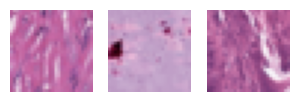

In [28]:
# Sample several test examples
X_test_sample = X_test[3:6]

# Get probability of each class from model
y_proba = cnn_model.predict(X_test_sample)
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)

plot_examples(X_test[3:], n_rows=1, n_cols=3)

## 3. Hyperparameter tuning

### Linear Regression

In [63]:
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)

# grid parameters
param_grid = {
    'C': [0.1, 1.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [500, 1000]
}

cvKFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [64]:
# Intialize and GridSearchCV
log_reg = LogisticRegression()
lr_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=cvKFold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Record the time
start_time = time.time()
lr_search.fit(X_train_pca, y_train)
end_time = time.time()
lr_elapsed_time = end_time - start_time

print("Best parameters found:", lr_search.best_params_)
print("Training time: {:.2f} seconds".format(lr_elapsed_time))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Training time: 39.20 seconds


In [66]:
results_df = pd.DataFrame(lr_search.cv_results_)
time_results = results_df[[
    'params', 'mean_fit_time', 'mean_score_time', 'mean_test_score'
]]
time_results.columns = ['Hyperparameters', 'Train Time (s)', 'Test Time (s)', 'Accuracy']

# Table
display(time_results)

,Hyperparameters,Train Time (s),Test Time (s),Accuracy
0,"{'C': 0.1, 'max_iter': 500, 'penalty': 'l1', '...",11.656425,0.107247,0.482539
1,"{'C': 0.1, 'max_iter': 500, 'penalty': 'l2', '...",26.147933,0.045753,0.476523
2,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...",9.168456,0.030896,0.482539
3,"{'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', ...",29.112407,0.023155,0.476523
4,"{'C': 1.0, 'max_iter': 500, 'penalty': 'l1', '...",9.883275,0.054700,0.481484
5,"{'C': 1.0, 'max_iter': 500, 'penalty': 'l2', '...",26.676086,0.017879,0.480703
6,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l1', ...",12.013857,0.030501,0.481523
7,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', ...",18.423157,0.008589,0.480703


### Feedforward Multilayer Perceptron Neural Network (MLP)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=0.8, random_state=42, stratify=y_train)

y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)

# Construct the model
def build_mlp_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 3)))
    
    # The first hidden layer
    model.add(Dense(units=hp.Int('units1', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # The second hidden layer
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(9, activation='softmax'))

    # learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize RandomSearch
tuner = kt.RandomSearch(
    build_mlp_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='mlp_tuner_dir',
    project_name='mlp_tuning'
)

tuner.search_space_summary()

early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=3,  
    restore_best_weights=True
)

Reloading Tuner from mlp_tuner_dir/mlp_tuning/tuner0.json
Search space summary
Default search space size: 7
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dropout1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [44]:
# Record the time
start_time = time.time()
tuner.search(X_train, y_train_cat,
             validation_data=(X_valid, y_valid_cat),
             epochs=20,
             callbacks=[early_stop],
             verbose=2)
end_time = time.time()

print(f"\nTotal tuning time: {(end_time - start_time):.2f} seconds")

mlp_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found by Keras Tuner:")
for param, value in mlp_best_hps.values.items():
    print(f"  {param}: {value}")


Total tuning time: 0.00 seconds
Best hyperparameters found by Keras Tuner:
  units: 128
  dropout: 0.4
  learning_rate: 0.0001


In [25]:
# Best model parameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

mlp_best_model = build_mlp_model(best_hps)

# Retraining
mlp_best_model.fit(X_train, y_train_cat,
               validation_data=(X_valid, y_valid_cat),
               epochs=20,
               callbacks=[early_stop],
               verbose=2)

# Last result
val_loss, val_acc = mlp_best_model.evaluate(X_valid, y_valid_cat, verbose=0)
print(f"\n[Refit] Best model validation accuracy: {val_acc:.4f}")


Epoch 1/20


/Users/yuhang/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


640/640 - 2s - 2ms/step - accuracy: 0.1829 - loss: 2.1380 - val_accuracy: 0.2439 - val_loss: 2.0112
Epoch 2/20
640/640 - 1s - 2ms/step - accuracy: 0.2282 - loss: 1.9953 - val_accuracy: 0.2389 - val_loss: 1.8973
Epoch 3/20
640/640 - 1s - 2ms/step - accuracy: 0.2411 - loss: 1.9354 - val_accuracy: 0.2705 - val_loss: 1.8618
Epoch 4/20
640/640 - 1s - 2ms/step - accuracy: 0.2542 - loss: 1.9005 - val_accuracy: 0.2881 - val_loss: 1.8244
Epoch 5/20
640/640 - 1s - 2ms/step - accuracy: 0.2654 - loss: 1.8699 - val_accuracy: 0.2840 - val_loss: 1.7894
Epoch 6/20
640/640 - 1s - 2ms/step - accuracy: 0.2816 - loss: 1.8412 - val_accuracy: 0.3107 - val_loss: 1.7585
Epoch 7/20
640/640 - 1s - 2ms/step - accuracy: 0.3041 - loss: 1.8048 - val_accuracy: 0.3701 - val_loss: 1.7535
Epoch 8/20
640/640 - 1s - 2ms/step - accuracy: 0.3152 - loss: 1.7800 - val_accuracy: 0.3912 - val_loss: 1.7015
Epoch 9/20
640/640 - 1s - 2ms/step - accuracy: 0.3243 - loss: 1.7620 - val_accuracy: 0.3725 - val_loss: 1.6698
Epoch 10/20


### Convolutional neural network

In [85]:
def build_cnn_model(
    filters: int = 32,
    kernel_size: int = 3,
    dropout_rate: float = 0.3,
    optimizer: str = "adam"
):
    model = Sequential([
        Conv2D(filters, (kernel_size, kernel_size), activation="relu",
               padding="same", input_shape=(28, 28, 3)),
        MaxPooling2D(),
        Conv2D(filters * 2, (kernel_size, kernel_size),
               activation="relu", padding="same"),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(dropout_rate),
        Dense(10, activation="softmax"),
    ])
    
    opt = Adam() if optimizer == "adam" else RMSprop()
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [14]:
# Wrap the build_cnn_model function in a scikit-learn compatible classifier:
cnn_clf = KerasClassifier(model=build_cnn_model, verbose=0)

In [15]:
#Random search tune on CNN
param_dist = {
    "model__filters":      [32, 64],                 
    "model__kernel_size":  [3, 5],
    "model__dropout_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
    "model__optimizer":    ["adam", "rmsprop"],
    "batch_size":          [32, 64],
    "epochs":              [10]
}

random_search = RandomizedSearchCV(
    estimator=cnn_clf,
    param_distributions=param_dist,
    n_iter=10,            
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    random_state=42       
)



In [16]:
random_search.fit(X_train, y_train)
best_wrapper = random_search.best_estimator_
best_cnn_model   = best_wrapper.model_

print("Best params:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


D:\ANACONDA\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best params: {'model__optimizer': 'adam', 'model__kernel_size': 3, 'model__filters': 64, 'model__dropout_rate': 0.2, 'epochs': 10, 'batch_size': 32}
Best CV accuracy: 0.7747667732546054


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Logistic regression

In [75]:
# Flatten & scale (assuming X_train, X_valid exist)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

X_train_scaled = scaler.fit_transform(X_train_flat)
X_valid_scaled = scaler.transform(X_valid_flat)

# PCA
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

# Final model with best params
lr_final_model = LogisticRegression(
    C=1.0, penalty='l2', solver='liblinear', max_iter=1000, random_state=42
)
lr_final_model.fit(X_train_pca, y_train)

# Evaluate
y_pred = lr_final_model.predict(X_valid_pca)
lr_final_acc = accuracy_score(y_valid, y_pred)
print(f"\n[Final Logistic Regression] Validation Accuracy: {lr_final_acc:.4f}")



[Final Logistic Regression] Validation Accuracy: 0.4847


### Fully connected neural network

In [77]:
mlp_final_model = Sequential([
    Flatten(input_shape=(28, 28, 3)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(9, activation='softmax')
])

mlp_final_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

mlp_final_model.fit(
    X_train, y_train_cat,
    validation_data=(X_valid, y_valid_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
val_loss, val_acc = mlp_final_model.evaluate(X_valid, y_valid_cat, verbose=0)
print(f"\n[Final MLP] Validation accuracy: {val_acc:.4f}")

E:\AVO\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
800/800 - 7s - 8ms/step - accuracy: 0.2144 - loss: 2.0690 - val_accuracy: 0.2339 - val_loss: 1.9486
Epoch 2/20
800/800 - 4s - 5ms/step - accuracy: 0.2478 - loss: 1.9511 - val_accuracy: 0.3067 - val_loss: 1.8754
Epoch 3/20
800/800 - 4s - 5ms/step - accuracy: 0.2559 - loss: 1.9073 - val_accuracy: 0.2738 - val_loss: 1.8310
Epoch 4/20
800/800 - 4s - 5ms/step - accuracy: 0.2714 - loss: 1.8744 - val_accuracy: 0.3102 - val_loss: 1.7991
Epoch 5/20
800/800 - 4s - 5ms/step - accuracy: 0.2819 - loss: 1.8466 - val_accuracy: 0.3080 - val_loss: 1.7818
Epoch 6/20
800/800 - 4s - 5ms/step - accuracy: 0.2901 - loss: 1.8262 - val_accuracy: 0.2989 - val_loss: 1.7495
Epoch 7/20
800/800 - 4s - 5ms/step - accuracy: 0.3055 - loss: 1.8053 - val_accuracy: 0.3583 - val_loss: 1.7295
Epoch 8/20
800/800 - 4s - 5ms/step - accuracy: 0.3141 - loss: 1.7856 - val_accuracy: 0.3705 - val_loss: 1.7155
Epoch 9/20
800/800 - 4s - 5ms/step - accuracy: 0.3187 - loss: 1.7791 - val_accuracy: 0.3872 - val_loss: 1.6994
E

### Convolutional neural network

In [91]:
#Fit the model with best wrapper
#Fit the model with best wrapper
best_optimizer     = 'adam'
best_kernel_size   = 3
best_filters       = 64
best_dropout_rate  = 0.2
best_epochs        = 10
best_batch_size    = 32
   
best_cnn_model = build_cnn_model(
    filters=best_filters,
    kernel_size=best_kernel_size,
    dropout_rate=best_dropout_rate,
    optimizer=best_optimizer
)

best_cnn_model.fit(
    X_train,
    y_train,
    batch_size=best_batch_size,
    epochs=best_epochs,
    verbose=1
)

E:\AVO\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.3392 - loss: 1.7185
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.6137 - loss: 1.0291
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.6701 - loss: 0.8930
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.7225 - loss: 0.7540
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7363 - loss: 0.7193
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.7467 - loss: 0.6938
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7595 - loss: 0.6490
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.7802 - loss: 0.6012
Epoch 9/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7923 - loss: 0.5564
Epoch 10/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.8066 - loss: 0.5180


In [92]:
#Compile model with loss, optimiser, and metrics
best_cnn_model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [93]:
# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 10
history = best_cnn_model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.8311 - loss: 0.4546 - val_accuracy: 0.8289 - val_loss: 0.4761
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - accuracy: 0.8544 - loss: 0.3930 - val_accuracy: 0.8238 - val_loss: 0.4846
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.8586 - loss: 0.3842 - val_accuracy: 0.8259 - val_loss: 0.4896
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 178ms/step - accuracy: 0.8710 - loss: 0.3561 - val_accuracy: 0.8280 - val_loss: 0.4871
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step - accuracy: 0.8677 - loss: 0.3552 - val_accuracy: 0.8320 - val_loss: 0.4657
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.8710 - loss: 0.3438 - val_accuracy: 0.8414 - val_loss: 0.4780
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - accuracy: 0.8856 - loss: 0.3185 - val_accuracy: 0.8459 - val_loss: 0.4393
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.8862 - loss: 0

In [94]:
# Evaluate the classifier on the test data.
loss, accuracy = best_cnn_model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8372 - loss: 0.4836
Accuracy on test data: 0.8342


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[5 1 2]


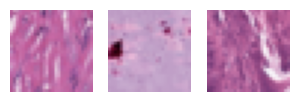

In [95]:
# Sample several test examples
X_test_sample = X_test[3:6]

# Get probability of each class from model
y_proba_cnn = best_cnn_model.predict(X_test_sample)
y_pred_cnn = np.argmax(y_proba_cnn, axis=-1)
print(y_pred_cnn)

plot_examples(X_test[3:], n_rows=1, n_cols=3)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


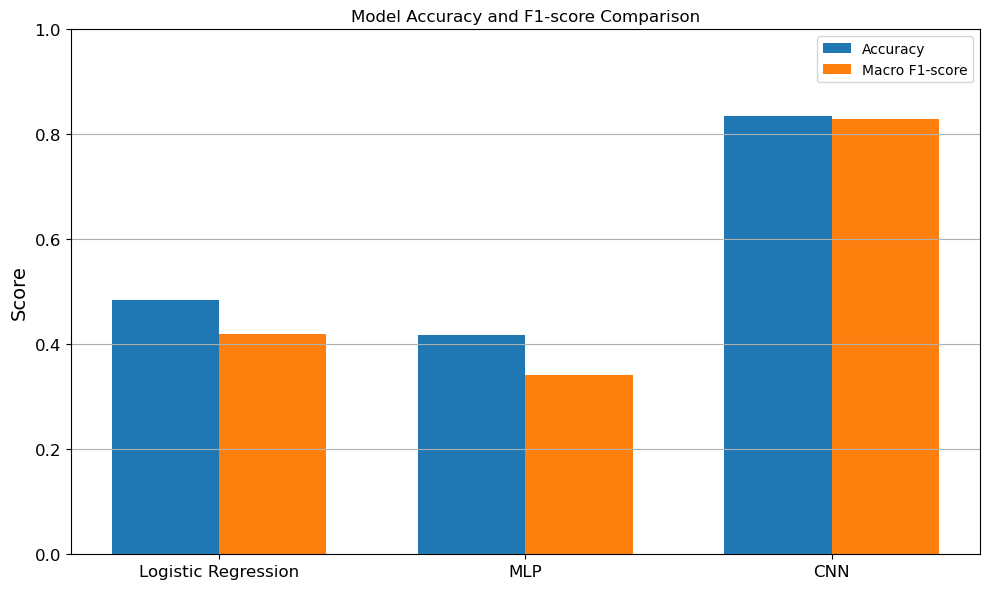

In [96]:
# Logistic Regression
y_pred_lr = lr_final_model.predict(X_valid_pca)
acc_lr = accuracy_score(y_valid, y_pred_lr)
f1_lr = f1_score(y_valid, y_pred_lr, average='macro')

# MLP
_, acc_mlp = mlp_final_model.evaluate(X_valid, y_valid_cat, verbose=0)
y_pred_mlp = np.argmax(mlp_final_model.predict(X_valid), axis=1)
f1_mlp = f1_score(y_valid, y_pred_mlp, average='macro')

# CNN
_, acc_cnn = best_cnn_model.evaluate(X_test, y_test, verbose=0)
y_pred_cnn = np.argmax(best_cnn_model.predict(X_test), axis=1)
f1_cnn = f1_score(y_test, y_pred_cnn, average='macro')

# Draw the bar plot
models = ['Logistic Regression', 'MLP', 'CNN']
accuracies = [acc_lr, acc_mlp, acc_cnn]
f1_scores = [f1_lr, f1_mlp, f1_cnn]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, f1_scores, width, label='Macro F1-score')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(x, models)
plt.title('Model Accuracy and F1-score Comparison')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


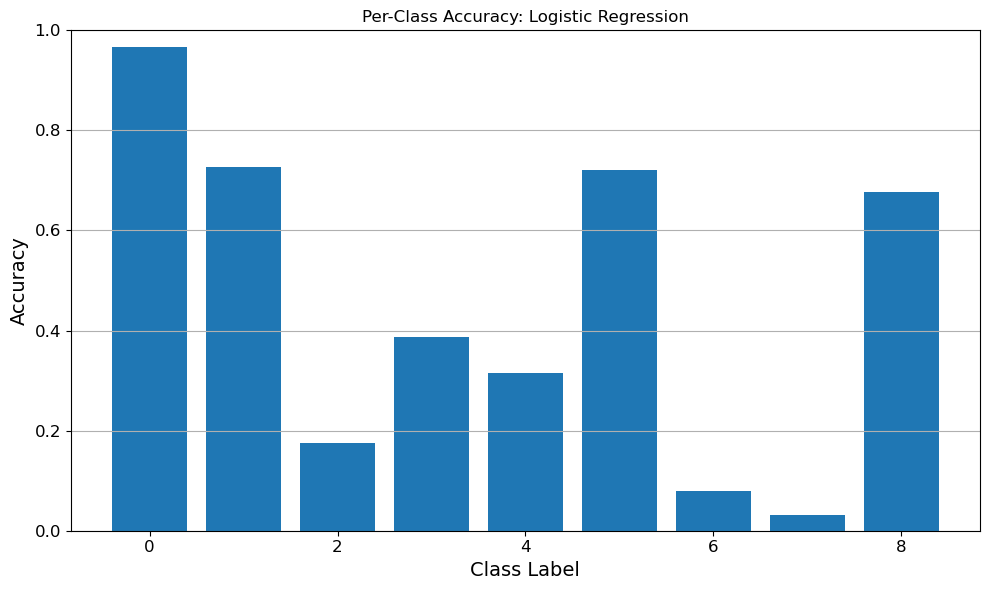

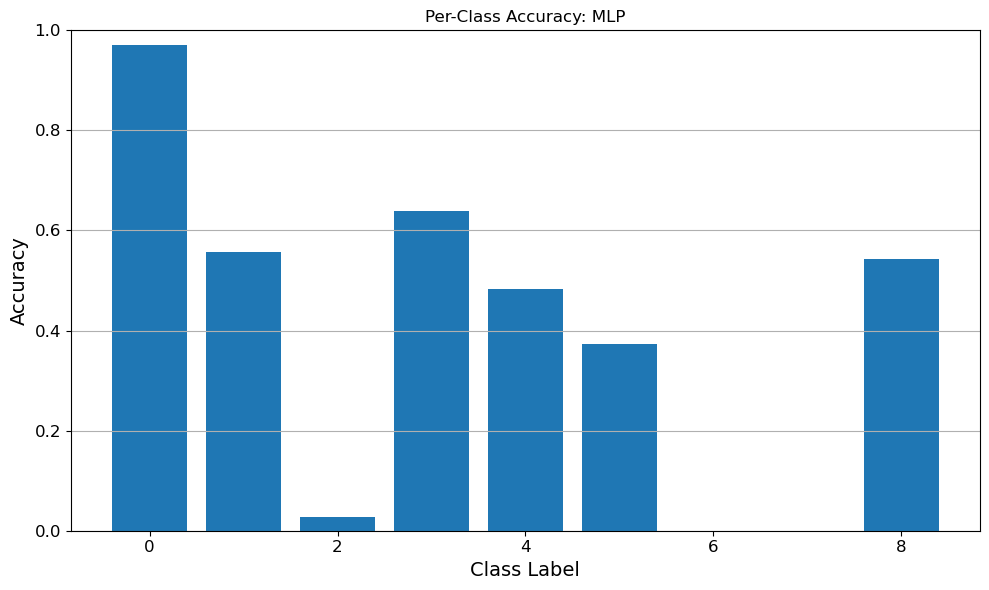

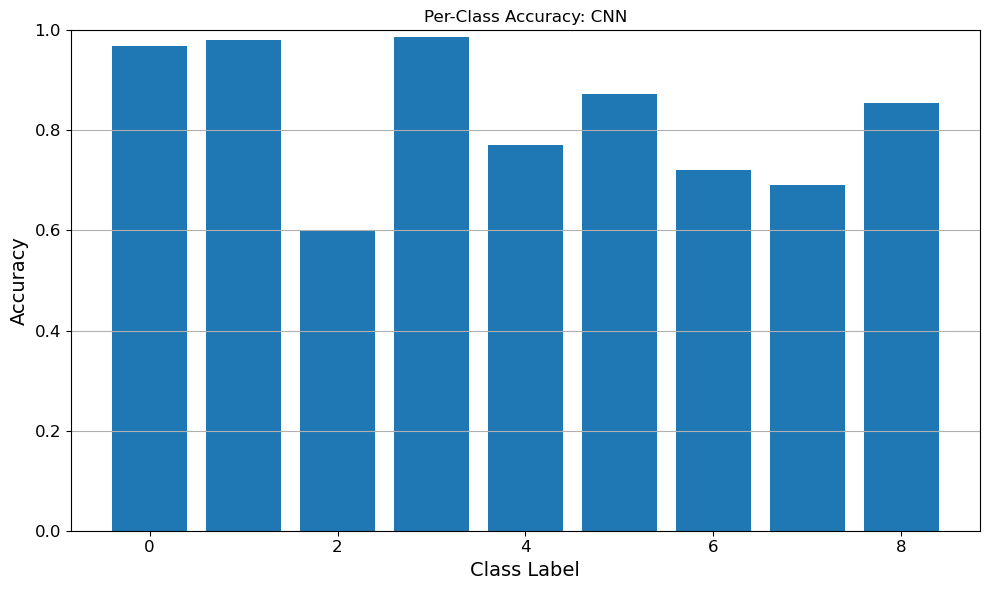

In [97]:
def plot_per_class_accuracy(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(per_class_acc)), per_class_acc)
    plt.title(f'Per-Class Accuracy: {model_name}')
    plt.xlabel('Class Label')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_per_class_accuracy(y_valid, y_pred_lr, "Logistic Regression")
plot_per_class_accuracy(y_valid, y_pred_mlp, "MLP")
plot_per_class_accuracy(y_test, y_pred_cnn, "CNN")


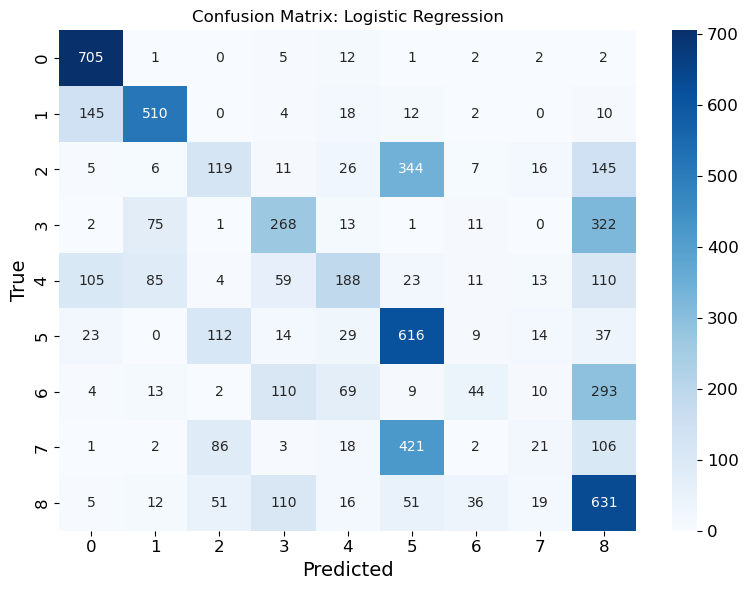

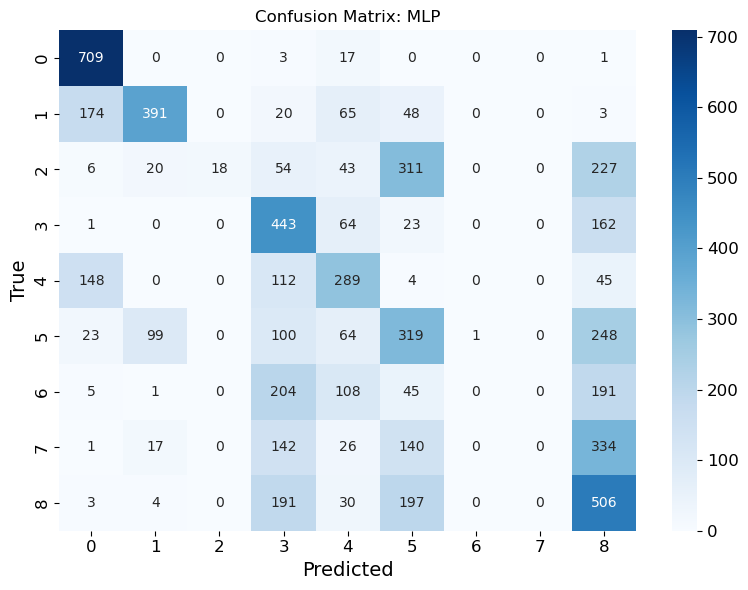

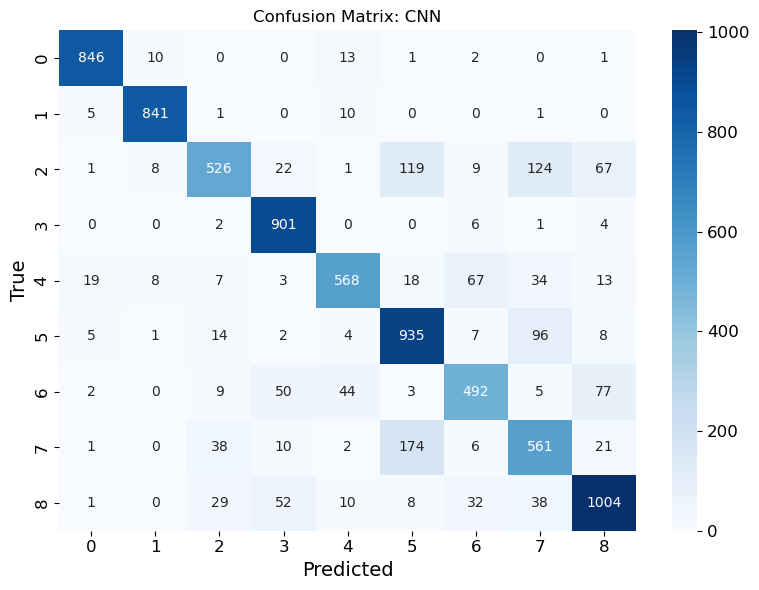

In [98]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_valid, y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_valid, y_pred_mlp, "MLP")
plot_confusion_matrix(y_test, y_pred_cnn, "CNN")


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Logistic Regression inference time: 0.0000 sec
MLP inference time              : 0.8046 sec
CNN inference time              : 3.6496 sec


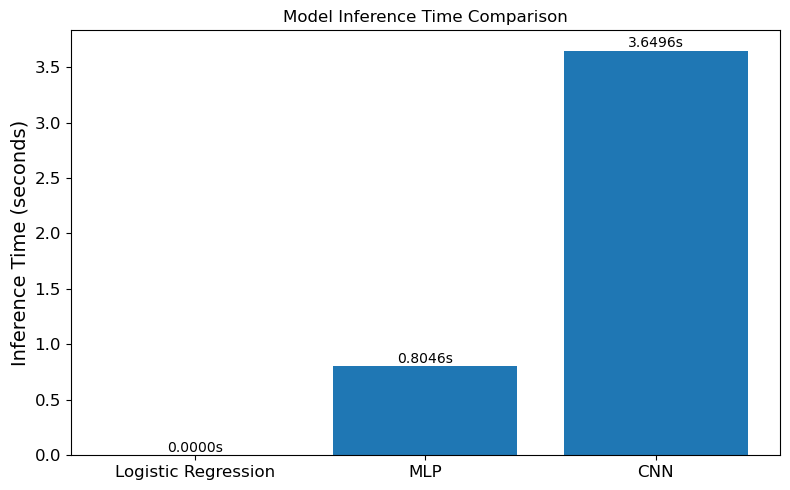

In [99]:
#time for Logistic Regression
start = time.time()
_ = lr_final_model.predict(X_valid_pca)
lr_infer_time = time.time() - start

#time for MLP
start = time.time()
_ = mlp_final_model.predict(X_valid)
mlp_infer_time = time.time() - start

#time for CNN
start = time.time()
_ = best_cnn_model.predict(X_test)
cnn_infer_time = time.time() - start

# print results
print(f"Logistic Regression inference time: {lr_infer_time:.4f} sec")
print(f"MLP inference time              : {mlp_infer_time:.4f} sec")
print(f"CNN inference time              : {cnn_infer_time:.4f} sec")

# draw bar plot
models = ['Logistic Regression', 'MLP', 'CNN']
times = [lr_infer_time, mlp_infer_time, cnn_infer_time]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, times)
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, t + 0.001, f"{t:.4f}s",
             ha='center', va='bottom', fontsize=10)
plt.ylabel('Inference Time (seconds)')
plt.title('Model Inference Time Comparison')
plt.tight_layout()
plt.show()


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


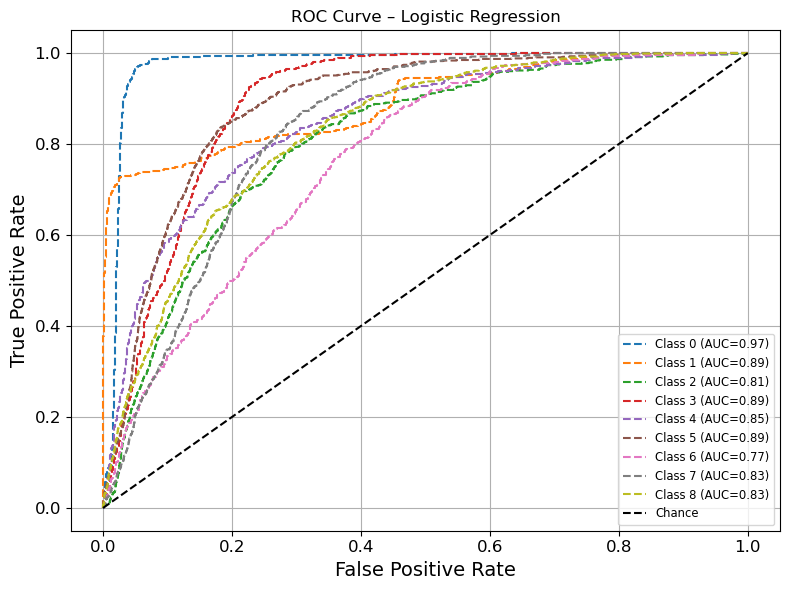

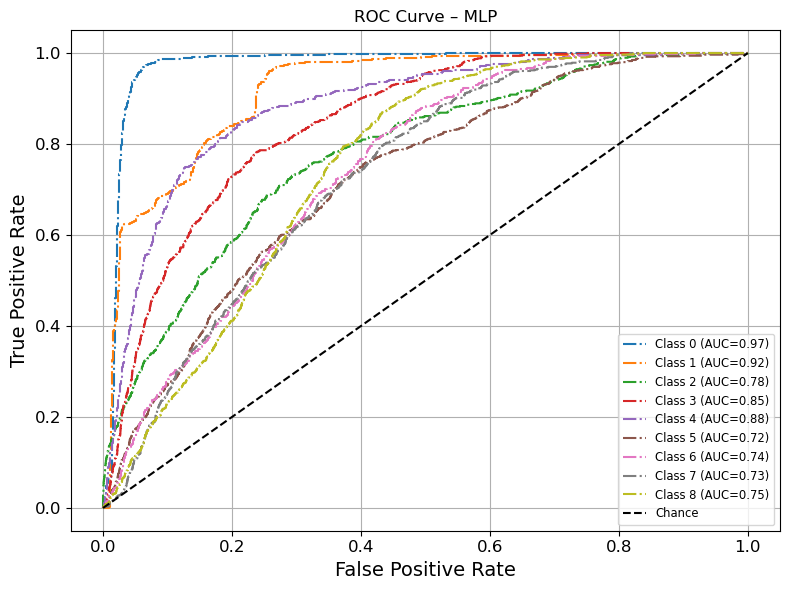

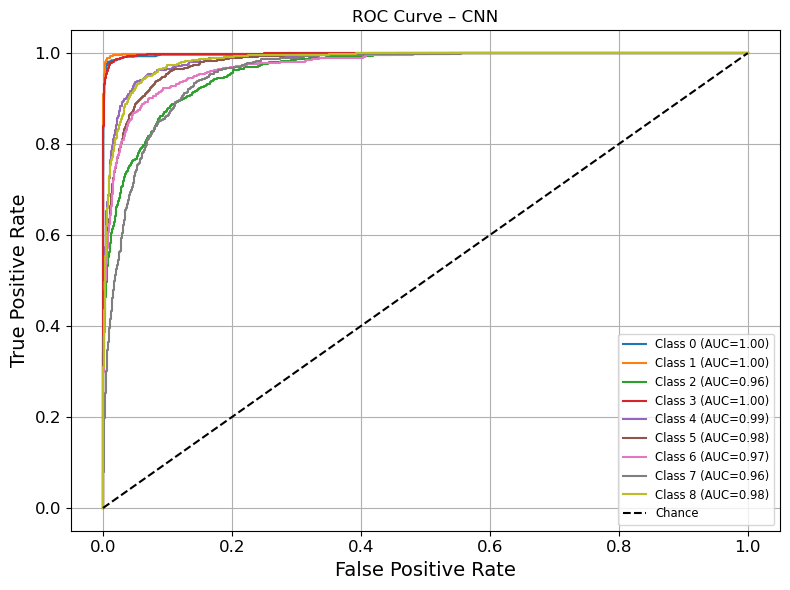

In [113]:
#1. Logistic Regression
all_labels = np.concatenate([y_valid, y_test])
classes = np.unique(all_labels)
n_classes = len(classes)
y_valid_bin = label_binarize(y_valid, classes=classes)
y_test_bin  = label_binarize(y_test,  classes=classes)
y_score_lr  = lr_final_model.predict_proba(X_valid_pca)  # shape (m_valid, n_classes)
y_score_mlp = mlp_final_model.predict(X_valid)           # shape (m_valid, n_classes)
y_score_cnn = best_cnn_model.predict(X_test)             # shape (m_test, n_classes)

fpr = {'lr': {}, 'mlp': {}, 'cnn': {}}
tpr = {'lr': {}, 'mlp': {}, 'cnn': {}}
roc_auc = {'lr': {}, 'mlp': {}, 'cnn': {}}
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_valid_bin[:, i], y_score_lr[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='--', label=f'Class {i} (AUC={roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. MLP
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_valid_bin[:, i], y_score_mlp[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='-.', label=f'Class {i} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – MLP')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. CNN
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_cnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='-', label=f'Class {i} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – CNN')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

